In [1]:
import json
import jellyfish
import re

In [2]:
def get_json(path):
    f = open(path,encoding="utf-8")
    liste = json.load(f, strict=False)
    f.close()
    return liste

In [3]:
def get_closest(title, number = 10, lowercase=True, path_compare ="all_burlesque_pages_corrected.json", word_filter = True ):
    """ 
  En entrée, une chaîne de caractère (et en option le nombre de titres proches à retourner, par défaut : 5)
  En sortie, la liste triée par ordre décroissant de similarité sous forme d'un triplet:
    distance, ID_moreau, titre concerné
  """
    liste_depart = get_json(path_compare)
    #all_burlesque_pages_original_ocr.json
    #all_burlesque_pages_ocr_without_linebreak.json
    #all_burlesque_pages_corrected_without_linebreak.json
    #all_burlesque_pages_corrected.json
    #all_burlesque_pages_ocr_without_space.json
    liste=[]
    if lowercase==True:
        for i in liste_depart:
            liste.append(word.lower() for word in i)
    mots_titre = set(title.split())
    filtered_list = []
    for ID, chaine in  liste:
        mots_candidat = set(chaine.split())
        inter = mots_titre.intersection(mots_candidat)
    ##Si moins de 5 mots en commun (ou de la moitié) inutile de garder le candidat
        if len(inter)>5 or len(inter)>(len(mots_titre)/2) or word_filter==False:
            filtered_list.append([len(inter), ID, chaine])
    f2 = []
    for len_inter, ID, chaine in filtered_list:
        sim = jellyfish.jaro_winkler(title,chaine)
    ## On garde quand la similarité est supérieure à 0.5
        if sim>0.5:
            f2.append([sim, ID, chaine])
    return sorted(f2, reverse=True)[:number]

In [4]:
path_ocr = "all_burlesque_pages_original_ocr.json"
path_clean = "all_burlesque_pages_corrected.json"

In [5]:
l_ocr = get_json(path_ocr)
l_clean = get_json(path_clean)

In [6]:
#OK_first = donne les stats de bons résultats en première position
#found = donne les stats quand la page est trouvée hors de la première position
#Intersection = donne le nombre de résultats en commun pour chaque individu de l'échantillon

dic_res = {True  : {"OK_first":{"ocr":0, "clean":0, "both":0}, "found": {"ocr":0, "clean":0, "both":0}, "intersections" : [] },
           False : {"OK_first":{"ocr":0, "clean":0, "both":0}, "found": {"ocr":0, "clean":0, "both":0}, "intersections" : [] }}

echantillon = 6

#Lancement de la fonction avec et sans le paramètre des 5 mots
for filter_status in [True, False]:
  for i in range(echantillon):
    ID, texte = l_ocr[i]
    res_ocr = get_closest(texte, lowercase=True, path_compare = path_ocr, word_filter = filter_status)
    liste_id_res_ocr = [x[1] for x in res_ocr]
    res_clean = get_closest(texte, lowercase=True, path_compare = path_clean, word_filter = filter_status)
    liste_id_res_clean = [x[1] for x in res_clean]
    
    #FOUND = résultats similaires dans les 10 premières sorties
    pos_ocr, pos_clean = -1, -1
    if ID.lower() in liste_id_res_ocr:
      pos_ocr = liste_id_res_ocr.index(ID.lower())
      dic_res[filter_status]["found"]["ocr"]+=1
    if ID.lower() in liste_id_res_clean:
      pos_clean = liste_id_res_clean.index(ID.lower()) 
      dic_res[filter_status]["found"]["clean"]+=1
    if ID.lower() in liste_id_res_ocr:
        dic_res[filter_status]["found"]["both"]+=1
    en_commun = set(liste_id_res_ocr).intersection(set(liste_id_res_clean))
    inter = len(en_commun)
    
    #OK_FIRST = résultats similaires en première page
    if pos_ocr ==0:
      dic_res[filter_status]["OK_first"]["ocr"]+=1
    if pos_ocr==pos_clean:
      dic_res[filter_status]["OK_first"]["both"]+=1
    if pos_clean ==0:
      dic_res[filter_status]["OK_first"]["clean"]+=1
    dic_res[filter_status]["intersections"].append(inter)
print(dic_res)

{True: {'OK_first': {'ocr': 6, 'clean': 4, 'both': 4}, 'found': {'ocr': 6, 'clean': 4, 'both': 6}, 'intersections': [1, 0, 2, 3, 6, 3]}, False: {'OK_first': {'ocr': 5, 'clean': 4, 'both': 4}, 'found': {'ocr': 6, 'clean': 4, 'both': 6}, 'intersections': [0, 2, 2, 3, 6, 3]}}


In [12]:
for filter_status in dic_res.keys():
  print(f"Word filter : {filter_status}")
  NB_pages = len(dic_res[filter_status]["intersections"])
  precision = dic_res[filter_status]["OK_first"]["both"]/NB_pages 
#Proportion des items pertinents parmi l'ensemble des items proposés = mesure de l'exactitude ou de la qualité
  rappel = dic_res[filter_status]["found"]["both"]/NB_pages
    #la proportion des items pertinents proposés parmi l'ensemble des items pertinents = mesure de l'exhaustivité ou de la quantité
  print(f"Précision : {precision} (support = {NB_pages}) ")
  print(f"Rappel : {precision} (support = {NB_pages}) ")

Word filter : True
Précision : 0.5 (support = 4) 
Rappel : 0.5 (support = 4) 
Word filter : False
Précision : 0.5 (support = 4) 
Rappel : 0.5 (support = 4) 


In [13]:
print(dic_res)

{True: {'OK_first': {'ocr': 4, 'clean': 2, 'both': 2}, 'found': {'ocr': 4, 'clean': 2, 'both': 4}, 'intersections': [1, 0, 2, 3]}, False: {'OK_first': {'ocr': 3, 'clean': 2, 'both': 2}, 'found': {'ocr': 4, 'clean': 2, 'both': 4}, 'intersections': [0, 2, 2, 3]}}


In [14]:
(dic_res[True]["intersections"])

[1, 0, 2, 3]

In [15]:
import matplotlib.pyplot as plt
import statistics
# Use: statistics.mean(liste)
 
from statistics import mean
# Use: mean(liste)

<built-in method index of list object at 0x000001EE1BE3B480>


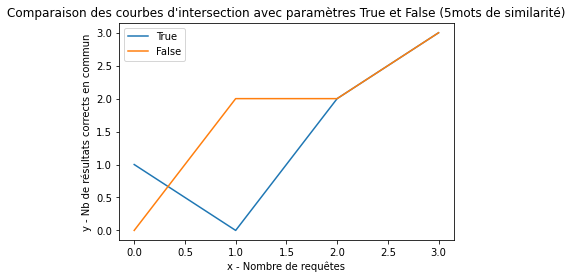

In [37]:
#Comparaison des courbes d'intersection avec paramètres True et False (5mots de similarité)
x=[0,1,2,3]
y_true=(dic_res[True]["intersections"])
y_false=(dic_res[False]["intersections"])
plt.plot(x,y_true,label='True')
plt.plot(x,y_false,label='False')
plt.xlabel("x - Nombre de requêtes")
plt.ylabel("y - Nb de résultats corrects en commun")
plt.title("Comparaison des courbes d'intersection avec paramètres True et False (5mots de similarité)")
plt.legend()
plt.show()
plt.close()
